## Notebook to implement AB testing after Model Evaluation

In [1]:
!rm -rf InkubaLM-Challenge
!git clone https://github.com/melissafasol/InkubaLM-Challenge.git
%cd InkubaLM-Challenge


Cloning into 'InkubaLM-Challenge'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 122 (delta 71), reused 72 (delta 29), pack-reused 0 (from 0)
Receiving objects: 100% (122/122), 679.13 KiB | 10.45 MiB/s, done.
Resolving deltas: 100% (71/71), done.
/content/InkubaLM-Challenge


In [52]:
%cd InkubaLM-Challenge
!git pull


[Errno 2] No such file or directory: 'InkubaLM-Challenge'
/content/InkubaLM-Challenge
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4 (delta 2), reused 4 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 1.76 KiB | 1.76 MiB/s, done.
From https://github.com/melissafasol/InkubaLM-Challenge
   2dbf104..8c900cb  main       -> origin/main
Updating 2dbf104..8c900cb
Fast-forward
 utils/new_model_function.py | 131 ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
 1 file changed, 131 insertions(+)
 create mode 100644 utils/new_model_function.py


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
!pip install -U trl bitsandbytes
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 335.7/335.7 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [54]:
import sys
sys.path.append("..")  # Add parent directory to the path

import os
from typing import List
from pathlib import Path
import numpy as np

# DO NOT EDIT
# create submission file
import pandas as pd
from huggingface_hub import login
from transformers import (
    AutoTokenizer,
)
from utils import (
    eval,
    model_function,
    multitask,
    experiment_logger,
    new_model_function
    )

import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, concatenate_datasets, Dataset, Value
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM
from peft import PeftModel

In [7]:
from google.colab import drive
drive.mount('/content/drive')
output_path = "/content/drive/MyDrive/InkubaLM-Challenge/Output"
os.makedirs(output_path, exist_ok=True)

Mounted at /content/drive


In [8]:
#os.environ["TOKENIZERS_PARALLELISM"] = "false"

from huggingface_hub import login

try:
    from google.colab import userdata

    # Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
    # vars as appropriate for your system.
    # userdata.get("HF_TOKEN") indicates that the name of the token in the Colab env is HF_TOKEN
    os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
except:
    os.environ["HF_TOKEN"] = "----"

login(token=os.environ["HF_TOKEN"])

token = os.environ["HF_TOKEN"]
if token == "----":
    print("⚠️ Warning: No Hugging Face token found. Some models may not load.")
else:
    login(token=token)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [24]:

print("# Loading datasets")
train_dataset = multitask.load_and_combine_datasets("Train")
test_dataset = multitask.load_and_combine_datasets("Test")

print("\n# Example from training dataset:")
print(train_dataset[0])

print("\n# Example from test dataset:")
print(test_dataset[0])

print("# Converting to DataFrame and extracting task types")
train_df = train_dataset.to_pandas()
train_df['task'] = train_df.ID.apply(multitask.extract_task_from_id)

print("\n# Dataset distribution by task:")
print(train_df.task.value_counts())



# Loading datasets
Common Columns: ['instruction', 'ID', 'inputs', 'langs', 'targets']
Common Columns: ['instruction', 'ID', 'inputs', 'langs', 'targets']

# Example from training dataset:
{'ID': 'ID_6aba33a1_sentiment_ dev_hausa', 'langs': 'hausa', 'instruction': 'Za ka iya tantance yanayin wannan rubutu? Bi waɗannan jagororin sharhi: Kyakkyawa: idan rubutu na nuna kyakkyawan tunani, hali, da yanayi. Korau: idan rubutu yana nuna mummunar tunani ko yanayi. Neutral: idan rubutu baya nuna kyakkyawar magana ko mara kyau kai tsaye ko a kaikaice.', 'inputs': '@user @user allah ya tsayyaba yar uwa 🎂 😍', 'targets': 'Kyakkyawa'}

# Example from test dataset:
{'ID': 'ID_f3c74c7b_sentiment_test__hausa', 'langs': 'hausa', 'instruction': "Gano ra'ayin da aka bayyana a cikin wannan rubutu. Bin waɗannan jagororin, kyakkyawa yana na rubutu na nufin kyakkyawan tunani, ɗabi'a, da motsin rai. Korau na nuna rubutu na nufin mummunan tunani ko motsin rai. Tsaka-tsaki na nuna rubutu baya nufin magana mai ky

## Still balancing dataset

## Load the original base model

In [25]:

from transformers import BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # or load_in_8bit=True for 8-bit quantization
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",  # or "fp4"
    bnb_4bit_compute_dtype=torch.bfloat16  # or torch.float16, depending on your hardware
)

model_name = "lelapa/InkubaLM-0.4B"
model, tokenizer, bnb_config = multitask.setup_model_and_tokenizer(model_name)

model = multitask.apply_lora_adapters(model)

trainable params: 524,288 || all params: 664,684,544 || trainable%: 0.0789


In [26]:
from transformers import AutoTokenizer
tok = AutoTokenizer.from_pretrained(model_name)
balanced_df = multitask.balance_target_lengths(train_df, tokenizer=lambda x: tok.tokenize(x))

print("\n# Analyzing target sequence lengths after balancing")
task_stats_after = multitask.analyze_task_lengths(balanced_df)

balanced_dataset = Dataset.from_pandas(balanced_df.reset_index(drop=True))


# Analyzing target sequence lengths after balancing
Target sequence length analysis by task:
Task: sentiment
count    400.0000
mean       7.0125
std        2.0756
min        4.0000
25%        5.0000
50%        7.5000
75%        9.0000
max        9.0000
Name: targets, dtype: float64
--------------------------------------------------
Task: mt
count    600.000000
mean      11.801667
std        8.347163
min        2.000000
25%        6.000000
50%       10.000000
75%       15.000000
max       62.000000
Name: targets, dtype: float64
--------------------------------------------------
Task: afrixnli
count    400.0
mean      18.0
std        0.0
min       18.0
25%       18.0
50%       18.0
75%       18.0
max       18.0
Name: targets, dtype: float64
--------------------------------------------------


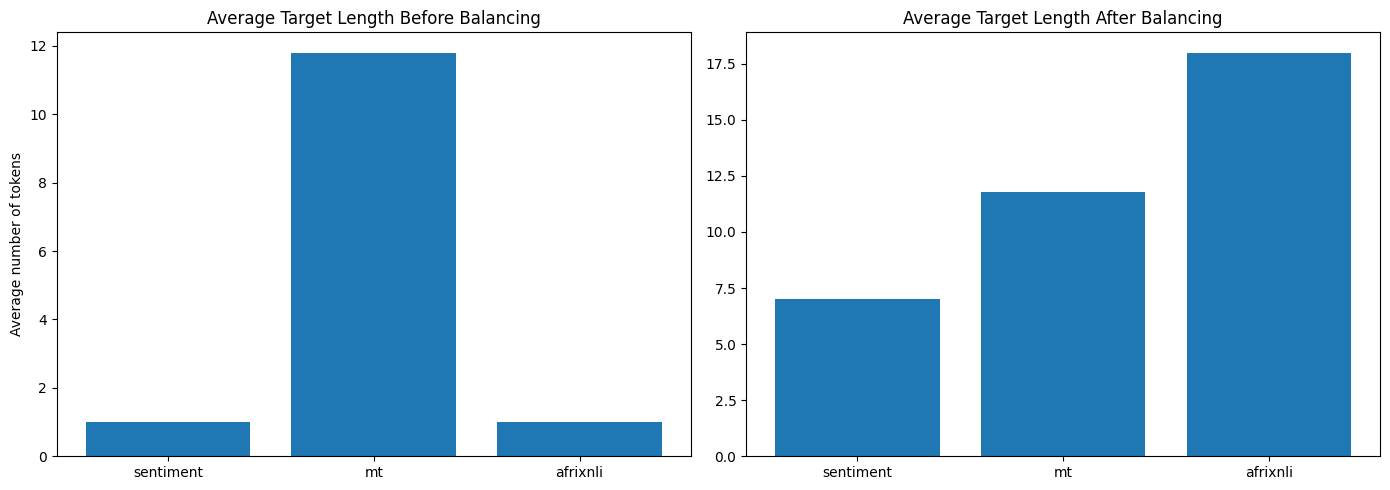

In [27]:
#testing balancing dataset more dynamically
multitask.plot_target_lengths(train_df, balanced_df)

## Splitting dataset into training and validation

In [28]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

# Stratified split (optional): to preserve task distribution
train_df_split, val_df_split = train_test_split(
    balanced_df,
    test_size=0.1,
    stratify=balanced_df["task"],
    random_state=42
)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df_split.reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df_split.reset_index(drop=True))


### Apply LoRA adapters

In [29]:
tok.pad_token = tok.eos_token


In [30]:

output_dir = "/content/drive/MyDrive/InkubaLM/outputs/best_model_dynamic_probabilistic_sampling"
os.makedirs(output_dir, exist_ok=True)
# Train
balanced_prob_trainer = multitask.setup_trainer_ab_testing(model, train_dataset, tokenizer=tok, output_dir=output_dir, val_dataset=val_dataset)
balanced_prob_trainer.train()

Applying formatting function to train dataset:   0%|          | 0/1260 [00:00<?, ? examples/s]

Converting train dataset to ChatML:   0%|          | 0/1260 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/1260 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1260 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1260 [00:00<?, ? examples/s]

Applying formatting function to eval dataset:   0%|          | 0/140 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/140 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/140 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/140 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/140 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss
10,4.010700,3.483903
20,3.204400,3.416911
30,3.665200,3.343147
40,3.358600,3.265754
50,3.141800,3.178820
60,3.038500,3.097216
70,2.959200,3.026018
80,2.988900,2.962298
90,3.164700,2.905453
100,2.827800,2.852103


TrainOutput(global_step=945, training_loss=2.405247025262742, metrics={'train_runtime': 1240.5776, 'train_samples_per_second': 3.047, 'train_steps_per_second': 0.762, 'total_flos': 1656597023539200.0, 'train_loss': 2.405247025262742})

In [31]:
def process_likelihood(likelihood_str: str) -> List[float]:
    """
    Process a likelihood string to clean and convert it to a list of floats.
    """
    # Clean the string to remove unwanted characters
    clean_str = (
        likelihood_str.replace("tensor(", "").replace(")", "").strip()
        .replace("[[", "").replace("]]", "").strip()
        .replace(" device='cuda:0'", "").replace(" dtype=torch.float16", "").strip()
        .replace("tensor", "").strip()
    )

    # Remove any empty strings caused by extra commas
    clean_str = clean_str.replace(",,", ",")  # Remove duplicate commas if they exist

    # Convert to a list of floats
    likelihood = [
        float(x) for x in clean_str.split(",") if x.strip()
    ]  # Ensure non-empty strings are converted
    return likelihood

def create_submission(output_path, test_flag: bool):
    """
    Creates submission files based on the provided test_flag.

    Args:
    test_flag (bool): If True, creates a test submission file; otherwise, creates a final submission file.
    """
    if test_flag:
        try:
            df1 = pd.read_csv(os.path.join(
                output_path,
                "hau_sent_prediction_dev.csv")
                 )
            df2 = pd.read_csv(os.path.join(
                output_path,
                "swa_sent_prediction_dev.csv")
            )
            df3 = pd.read_csv(os.path.join(
                output_path,
                "hau_mt_prediction_dev.csv")
                             )
            df4 = pd.read_csv(os.path.join(
                output_path,
                "swa_mt_prediction_dev.csv"))
            df5 = pd.read_csv(os.path.join(
                output_path,
                "hau_xnli_prediction_dev.csv"))
            df6 = pd.read_csv(os.path.join(
                output_path,
                "swa_xnli_prediction_dev.csv"))
        except FileNotFoundError as e:
            print(
                "Seems you have not completed all the tasks, please complete all the tasks before attempting to create your submission file"
            )
            raise e
    else:
        filename = "submission.csv"
        try:
            df1 = pd.read_csv(os.path.join(
                output_path,
                "hau_sent_prediction.csv"))
            df2 = pd.read_csv(os.path.join(
                output_path,
                "swa_sent_prediction.csv"))
            df3 = pd.read_csv(os.path.join(
                output_path,
                "hau_mt_prediction.csv"))
            df4 = pd.read_csv(os.path.join(
                output_path,
                "swa_mt_prediction.csv"))
            df5 = pd.read_csv(os.path.join(
                output_path,
                "hau_xnli_prediction.csv"))
            df6 = pd.read_csv(os.path.join(
                output_path,
                "swa_xnli_prediction.csv"))
        except FileNotFoundError as e:
            print(
                "Seems you have not completed all the tasks, please complete all the tasks before attempting to create your submission file"
            )
            raise e

    # Combine and process data
    resmt = pd.concat([df3, df4], ignore_index=True)
    res_log = pd.concat([df1, df2, df5, df6], ignore_index=True)
    res_log.drop(columns=["Response"], inplace=True)
    res_log.rename(columns={"Log-Likelihood": "Response"}, inplace=True)
    res = pd.concat([res_log, resmt], ignore_index=True)

    def process_row(row):
        if "xnli" in row["ID"] or "sent" in row["ID"]:
            likelihoods = process_likelihood(row["Response"])
            predicted_label = np.argmax(likelihoods)
            return predicted_label
        return row["Response"]  # Default for other cases

    # Update the Response column in-place
    res["Response"] = res.apply(process_row, axis=1)

    if test_flag:
        filename = os.path.join(
                output_path,
                "submission_test.csv")
        # Save the submission file
        submission = res[["ID", "Response", "Targets"]]
        submission.to_csv(filename, index=False)
    else:
        filename = os.path.join(
                output_path,
                "submission.csv")
        # Save the submission file
        submission = res[["ID", "Response"]]
        submission.to_csv(filename, index=False)
    return submission

In [80]:
import os

# Make sure output directory exists
output_path = "Output"
os.makedirs(output_path, exist_ok=True)

BASE_PROMPT = (
    "Below is an instruction that describes a task, paired with an input that provides further context. "
    "Write a response that appropriately completes the request.\n\n"
    "### Instruction: {}\n\n"
    "### Response:"
)

# Static instructions
instruction_map = {
    "sent": "Please identify the sentiment reflected in this text based on the following guidelines: Positive: if a text implies positive sentiment, attitude, and emotional state. Negative: if a text implies negative sentiment or emotion. Neutral: if a text does not imply positive or negative language directly or indirectly. Provide sentiment labels only",
    "xnli": "Is the following question True, False or Neither?",
    "mt": "Translate the following from {input_lang} into {output_lang}."
}

# Dataset dictionary with matching task keys
datasets = {
    "sent": dataset_dict_sent,
    "xnli": dataset_dict_xnli,
    "mt": dataset_dict_mt
}

SAMPLE_SIZE = 50

# Run inference for each task and language
for task_key, dataset_dict in datasets.items():
    for lang, dataset in dataset_dict.items():
        print(f"\n🔁 Running task: {task_key} | Language: {lang}")

        # Match filename format: "hau_sent_prediction.csv"
        filename = f"{lang[:3]}_{task_key}_prediction_dev.csv"  # truncates to hau/swa
        filepath = os.path.join(output_path, filename)

        # Handle instruction
        if task_key == "mt":
            instruction = instruction_map[task_key].format(
                input_lang=lang,
                output_lang="english"
            )
            custom_instruct = True
        else:
            instruction = instruction_map[task_key]
            custom_instruct = True  # Set to False if you'd rather use dataset instructions

        # Run inference
        new_model_function.main(
            model=lora_model,
            tokenizer=tokenizer,
            BASE_PROMPT=BASE_PROMPT,
            task_instruction=instruction,
            dataset=dataset,
            csv_file_path=filepath,
            custom_instruct=custom_instruct,
            sample_size=SAMPLE_SIZE,
            max_new_tokens=10,
            do_sample=False,
            temperature=0.0,
            top_k=1
        )
        print(f"✅ Saved: {filepath}")




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



🔁 Running task: sent | Language: swahili


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

✅ Saved: Output/swa_sent_prediction_dev.csv

🔁 Running task: sent | Language: hausa


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

✅ Saved: Output/hau_sent_prediction_dev.csv

🔁 Running task: xnli | Language: swahili
✅ Saved: Output/swa_xnli_prediction_dev.csv

🔁 Running task: xnli | Language: hausa
✅ Saved: Output/hau_xnli_prediction_dev.csv

🔁 Running task: mt | Language: swahili
✅ Saved: Output/swa_mt_prediction_dev.csv

🔁 Running task: mt | Language: hausa
✅ Saved: Output/hau_mt_prediction_dev.csv


In [77]:
offline = False
output_path = "../Output/"

In [81]:
create_submission(output_path=output_path, test_flag=True)

,ID,Response,Targets
0,ID_6aba33a1_sentiment_ dev_hausa,1,Kyakkyawa
1,ID_ce64d307_sentiment_ dev_hausa,1,Tsaka-tsaki
2,ID_2efc9515_sentiment_ dev_hausa,1,Tsaka-tsaki
3,ID_495cd199_sentiment_ dev_hausa,1,Korau
4,ID_bd9d751e_sentiment_ dev_hausa,1,Korau
...,...,...,...
95,ID_2c7bd2ee_sentiment_ dev_swahili,1,Chanya
96,ID_26def408_sentiment_ dev_swahili,1,Chanya
97,ID_3639631f_sentiment_ dev_swahili,1,Chanya
98,ID_3cab437a_sentiment_ dev_swahili,1,Hasi


In [83]:
from utils.eval import evaluate_zindi  # Adjust if the function is in a different path

zindi_score, detailed_scores = evaluate_zindi("Output/submission_test.csv")

print("🔥 Zindi Score:", zindi_score)
print("📊 Breakdown:", detailed_scores)


🔥 Zindi Score: nan
📊 Breakdown: {'sentiment_f1': np.float64(0.2252), 'nli_f1': np.float64(0.0), 'mt_chrf': np.float64(nan), 'zindi_score': np.float64(nan)}


In [45]:
balanced_prob_trainer.save_model("outputs/best_model_dynamic_probabilistic")
tok.save_pretrained("outputs/best_model_dynamic_probabilistic")

('outputs/best_model_dynamic_probabilistic/tokenizer_config.json',
 'outputs/best_model_dynamic_probabilistic/special_tokens_map.json',
 'outputs/best_model_dynamic_probabilistic/tokenizer.model',
 'outputs/best_model_dynamic_probabilistic/added_tokens.json',
 'outputs/best_model_dynamic_probabilistic/tokenizer.json')

In [46]:
balanced_prob_trainer.model.save_pretrained("/content/drive/MyDrive/InkubaLM/outputs/best_model_dynamic_probabilistic")


## Load balanced model with dynamic tokens

In [47]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel, PeftConfig

# Load base model
base_model = AutoModelForCausalLM.from_pretrained("lelapa/InkubaLM-0.4B", device_map="auto")

# Load LoRA adapter
lora_model = PeftModel.from_pretrained(
    base_model,
    "/content/drive/MyDrive/InkubaLM/outputs/best_model_dynamic_probabilistic"
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("lelapa/InkubaLM-0.4B")


In [13]:
results_df = multitask.apply_inference_to_test_data(lora_model, tokenizer, test_dataset)
results_df.to_csv("submission_test.csv", index=False)


Generating Responses:   0%|          | 0/900 [00:00<?, ?it/s]

In [15]:
results_df

,ID,langs,instruction,inputs,targets,generated,Response
0,ID_f3c74c7b_sentiment_test__hausa,hausa,Gano ra'ayin da aka bayyana a cikin wannan rub...,@user ynxu fha da kanada kudi shikenan duk kay...,None,👇 👇 👇 👇,0
1,ID_aad19dbf_sentiment_test__hausa,hausa,Za ka iya tantance yanayin wannan rubutu? Bi w...,@user alhamdulillah babu abinda zamuce sai god...,None,🙏 🙏 🙏 🙏,0
2,ID_f6de0381_sentiment_test__hausa,hausa,Za ka iya tantance yanayin wannan rubutu? Bi w...,@user ke ina ruwan ki 😬 ba harkar film bane ba,None,😬 😬 😬 😬,0
3,ID_cbec84fe_sentiment_test__swahili,swahili,Changanua mawazo ya matini yanayofuata na uain...,matokeo chanya liverais magufuli katika uzindu...,None,Wastani Wastani Wastani Wastani Wastani Wastan...,1
4,ID_885caf5c_sentiment_test__hausa,hausa,Tantance ra’ayin wannan rubutu kuma a rarraba ...,@user 🤣 akwai lauje cikin nadi gaskiya.,None,🤣 🤣 🤣 🤣,0
...,...,...,...,...,...,...,...
895,ID_88cd08fe_test__afrixnli_hau,hau,"Is the following question True, False or Neither?",Bradley ya fito daga Missouri.,None,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,0
896,ID_404bc9af_test__afrixnli_swa,swa,"Is the following question True, False or Neither?",Brahma ni sehemu muhimu zaidi ya utatu.,None,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,0
897,ID_a399ed32_test__afrixnli_swa,swa,"Is the following question True, False or Neither?",Ilinichukua muda wa miezi 13 kukiweka kichemsh...,None,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1,1
898,ID_9f28a032_test__afrixnli_hau,hau,"Is the following question True, False or Neither?",an hada da nazarin Marxist-Leninist a harkar k...,None,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,0


In [18]:


def get_task_type(row):
    if "sentiment" in row["ID"]:
        return "sentiment"
    elif "xnli" in row["ID"]:
        return "nli"
    elif "mt" in row["ID"]:
        return "mt"
    else:
        return "unknown"

results_df["task"] = results_df.apply(get_task_type, axis=1)

In [19]:
results_df

,ID,langs,instruction,inputs,targets,generated,Response,task
0,ID_f3c74c7b_sentiment_test__hausa,hausa,Gano ra'ayin da aka bayyana a cikin wannan rub...,@user ynxu fha da kanada kudi shikenan duk kay...,None,👇 👇 👇 👇,0,sentiment
1,ID_aad19dbf_sentiment_test__hausa,hausa,Za ka iya tantance yanayin wannan rubutu? Bi w...,@user alhamdulillah babu abinda zamuce sai god...,None,🙏 🙏 🙏 🙏,0,sentiment
2,ID_f6de0381_sentiment_test__hausa,hausa,Za ka iya tantance yanayin wannan rubutu? Bi w...,@user ke ina ruwan ki 😬 ba harkar film bane ba,None,😬 😬 😬 😬,0,sentiment
3,ID_cbec84fe_sentiment_test__swahili,swahili,Changanua mawazo ya matini yanayofuata na uain...,matokeo chanya liverais magufuli katika uzindu...,None,Wastani Wastani Wastani Wastani Wastani Wastan...,1,sentiment
4,ID_885caf5c_sentiment_test__hausa,hausa,Tantance ra’ayin wannan rubutu kuma a rarraba ...,@user 🤣 akwai lauje cikin nadi gaskiya.,None,🤣 🤣 🤣 🤣,0,sentiment
...,...,...,...,...,...,...,...,...
895,ID_88cd08fe_test__afrixnli_hau,hau,"Is the following question True, False or Neither?",Bradley ya fito daga Missouri.,None,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,0,nli
896,ID_404bc9af_test__afrixnli_swa,swa,"Is the following question True, False or Neither?",Brahma ni sehemu muhimu zaidi ya utatu.,None,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,0,nli
897,ID_a399ed32_test__afrixnli_swa,swa,"Is the following question True, False or Neither?",Ilinichukua muda wa miezi 13 kukiweka kichemsh...,None,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1,1,nli
898,ID_9f28a032_test__afrixnli_hau,hau,"Is the following question True, False or Neither?",an hada da nazarin Marxist-Leninist a harkar k...,None,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,0,nli


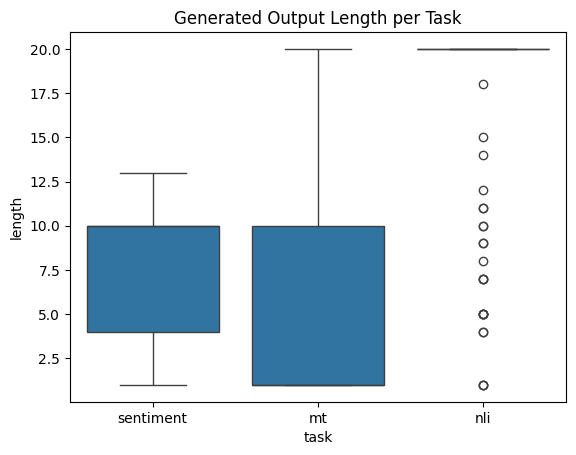

In [20]:

import seaborn as sns
import matplotlib.pyplot as plt

results_df["length"] = results_df["generated"].str.split().apply(len)

sns.boxplot(data=results_df, x="task", y="length")
plt.title("Generated Output Length per Task")
plt.show()


In [21]:

repetitive = results_df[results_df["generated"].str.contains(r"\b(\w+)( \1\b){3,}", regex=True, na=False)]
print(f"Repetitive outputs: {len(repetitive)} / {len(results_df)}")



Repetitive outputs: 529 / 900
